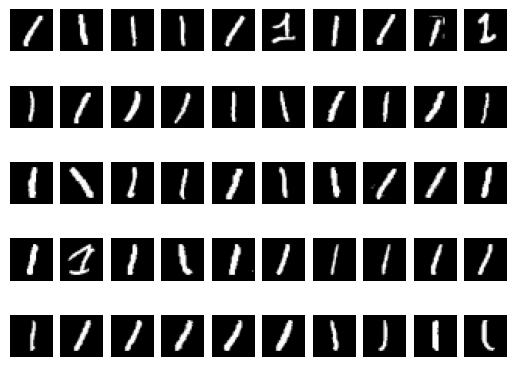

In [41]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Filter the images of digit 1
digit_1_indices = [i for i, label in enumerate(y_train) if label == 1]
digit_1_indices_test = [i for i, label in enumerate(y_test) if label == 1]
x_digit_1 = x_train[digit_1_indices[:50]]
x_digit_1_test = x_train[digit_1_indices_test[:50]]

# Display the first 50 images of digit 1
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(x_digit_1[i], cmap='gray')
    plt.axis('off')
plt.show()

In [7]:
from skimage.transform import resize
import numpy as np

x_digit_1 = x_digit_1 / 255.0
x_digit_1_resized = []
for image in x_digit_1:
    resized_image = resize(image, (16, 16))
    x_digit_1_resized.append(resized_image)

x_digit_1_resized = np.array(x_digit_1_resized)
x_digit_1_resized_flat = x_digit_1_resized.reshape(x_digit_1_resized.shape[0], -1)

In [42]:
x_digit_1_test = x_digit_1_test / 255.0
x_digit_1_resized_test = []
for image in x_digit_1_test:
    resized_image = resize(image, (16, 16))
    x_digit_1_resized_test.append(resized_image)

x_digit_1_resized_test = np.array(x_digit_1_resized_test)
x_digit_1_resized_flat_test = x_digit_1_resized_test.reshape(x_digit_1_resized_test.shape[0], -1)

In [8]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

In [9]:
def auto_encoder_ckt(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")

    ckt = QuantumCircuit(qr, cr)
    ansatz_ckt = RealAmplitudes(num_latent + num_trash, reps = 5)
    ckt.compose(ansatz_ckt, range(0, num_latent + num_trash), inplace=True)
    ckt.barrier()

    aux_qubit = num_latent + 2 * num_trash

    #SwapTest
    ckt.h(aux_qubit)
    for i in range(num_trash):
        ckt.cswap(aux_qubit, num_latent + i, num_latent + num_trash + i)
    
    ckt.h(aux_qubit)
    ckt.measure(aux_qubit, cr[0])

    return ckt

In [10]:
num_latent = 6
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_ckt(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

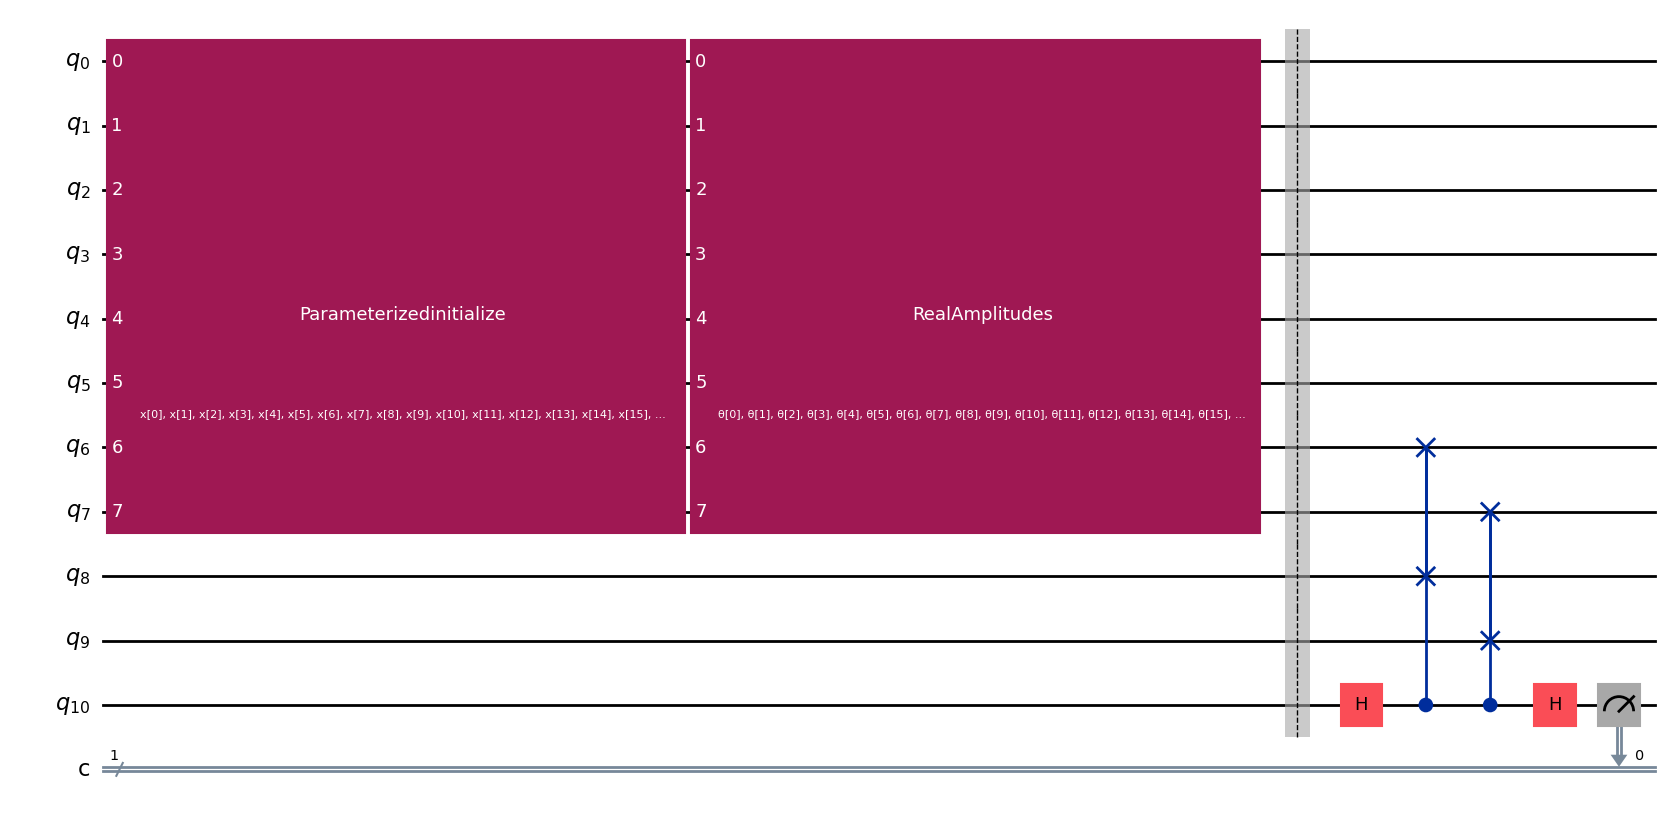

In [11]:
qc.draw('mpl')

In [12]:
def identity_interpret(x): return x

In [13]:
num_of_digits = 10
qnn = SamplerQNN(
    circuit = qc,
    input_params = fm.parameters,
    weight_params = ae.parameters,
    interpret = identity_interpret,
    output_shape = num_of_digits,
)

In [14]:
from qiskit_algorithms.optimizers import COBYLA
opt = COBYLA(maxiter=500)

In [15]:
training_data = x_digit_1_resized_flat
def cost_func_digits(params_value):
    prob = qnn.forward(training_data, params_value)
    cost = np.sum(prob[:, 1]) / training_data.shape[0]
    return cost

In [16]:
from qiskit_algorithms.utils import algorithm_globals
initial_point = algorithm_globals.random.random(ae.num_parameters)
opt_result = opt.minimize(fun = cost_func_digits, x0 = initial_point)

In [39]:
optimized_params = opt_result.x
print(optimized_params)

[-0.47154222  0.16473291  1.00186613  0.49308674  0.66403883  0.09041085
 -0.13896073  0.17790145  1.82103247  1.24508953  1.90802811  1.37588399
  1.88571144 -1.40737895 -1.03324224  1.33544183  0.99850519 -0.57829887
  0.88858767  0.67352156  2.21691936  0.39672791 -1.0946112   0.35022636
 -0.25748005  0.95842503  0.74851181  0.92353758  0.59175117  1.47302052
 -0.25214109  0.83294348  1.38603386 -0.48793939  0.22261564  0.46981129
  0.6965587   1.05626461 -0.0789678   0.00351117  0.55372074  0.10718119
  0.97284805  1.13217987  0.69058516  0.39462807 -1.62011866  1.63131032]


In [43]:
test_data = x_digit_1_resized_flat_test

# Perform forward propagation with the optimized parameters
predictions = qnn.forward(test_data, optimized_params)

# For binary classification, you may want to look at the second column (i.e., label 1) probabilities
# You can interpret these probabilities to classify or analyze further.
predicted_classes = np.argmax(predictions, axis=1)

# Example: Printing out the predicted classes (for the digit 1 case)
print("Predicted classes: ", predicted_classes)

Predicted classes:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [27]:

test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = RealAmplitudes(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(7)
test_qc.reset(6)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

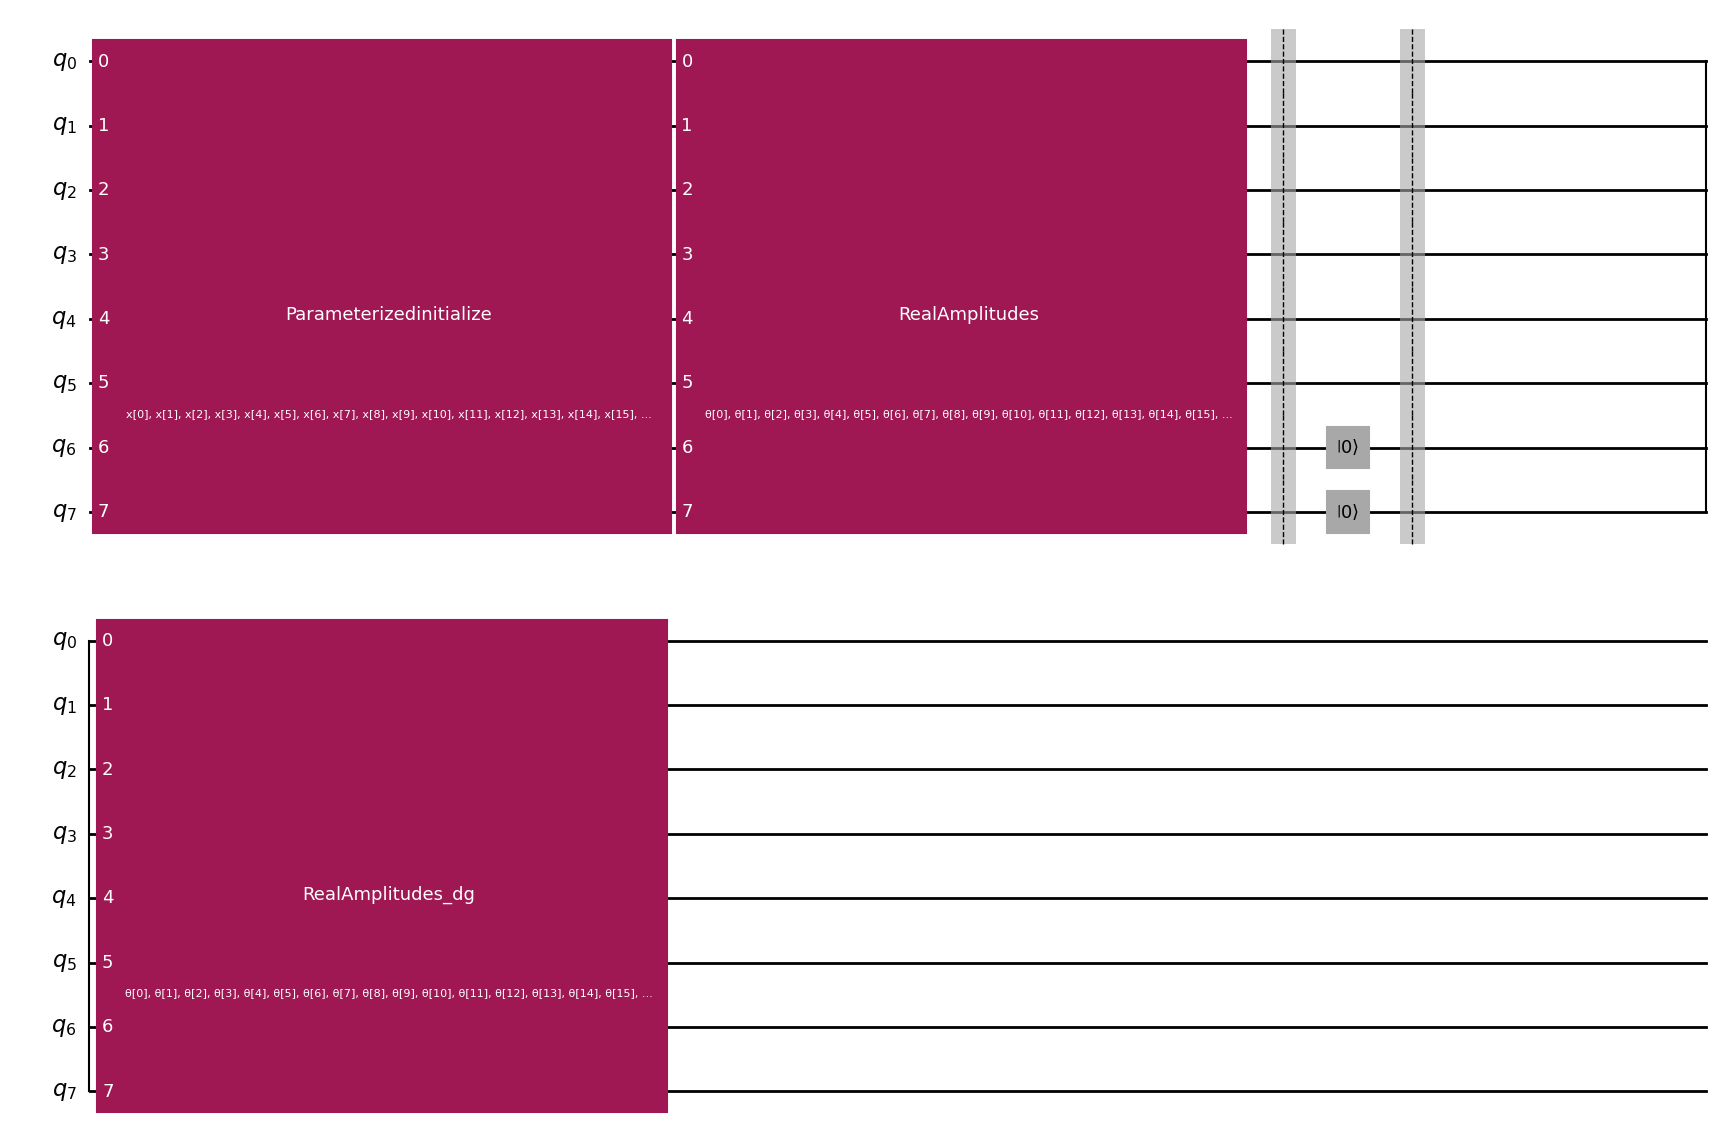

In [28]:
test_qc.draw('mpl')

In [29]:
def calculate_fidelity(sv1: np.ndarray, sv2: np.ndarray) -> float:
    return np.sqrt(np.dot(sv1.flatten().conj(), sv2.flatten()) ** 2)